In [2]:
import numpy as np
import torch
import time
from matplotlib import pyplot as plt
FUN = torch.nn.functional

### Testing the properties of the distribution
The distribution is obtained passing a uniform distribution through a layer/neuron

In [1]:
def test_neuron(neu_class, inp_dim, iter=100, batch=200, params=[]):
    res = []
    for i in range(iter):
        neu = neu_class(inp_dim, *params)
        res.append(neu(torch.rand(batch, inp_dim)))
    return torch.stack(res, dim=0)

def test_neuron_var(neu_class, inp_dim, iter=100, batch=200, params=[]):
    res = []
    for i in range(iter):
        neu = neu_class(inp_dim, *params)
        res.append(torch.var(neu(torch.rand(batch, inp_dim))))
    return torch.stack(res, dim=0)

### Empirical Test of L-Infinity neurons

In [31]:
class l_p(object):
    
    def __init__(self, inp_dim, p=torch.inf):
        self.w = torch.rand(inp_dim)
        self.b = torch.rand(1)
        self.p = p

    def __call__(self, x):
        return torch.norm(x - self.w, p=self.p, dim=-1) + self.b

class direct_max(object):

    def __init__(self, inp_dim):
        self.w = torch.rand(inp_dim)
        self.b = torch.rand(1)

    def __call__(self, x):
        return torch.amax(x - self.w, dim=-1) + self.b

class bt_four(object):

    def __init__(self, inp_dim, p=torch.inf):
        assert inp_dim == 4
        self.w1 = torch.rand(4)
        self.w2 = torch.rand(2)
        self.b = torch.rand(1)
        self.p = p

    def __call__(self, x):
        r1 = torch.norm((x - self.w1).reshape(x.shape[:-1] + (2, 2)), p=self.p, dim=-1)
        r2 = torch.norm(r1 - self.w2, p=self.p, dim = -1)
        return r2 + self.b

class minimax_four(object):

    def __init__(self, inp_dim):
        assert inp_dim == 4
        self.w1 = torch.rand(4)
        self.w2 = torch.rand(2)
        self.b = torch.rand(1)
    
    def __call__(self, x):
        r1 = torch.amax((x - self.w1).reshape(x.shape[:-1] + (2, 2)), dim=-1)
        r2 = torch.amin(r1 - self.w2, dim=-1)
        return r2 + self.b

class bt_weighted_four(object):

    def __init__(self, inp_dim, p=torch.inf):
        eps = 0.005
        self.p = p
        assert inp_dim == 4
        self.m1 = torch.rand(4, 1)
        sum_m1 = torch.sum(self.m1, dim=0) + eps
        self.m1 /= sum_m1
        self.w1 = torch.rand(1)
        self.b = torch.rand(1)

    def __call__(self, x):
        return torch.norm(torch.mm(x, self.m1) - self.w1, p=self.p, dim=-1) + self.b


In [32]:
res_naive = test_neuron_var(naive_four, 4, 4000, 10000)
res_bt = test_neuron_var(bt_four, 4, 4000, 10000)
res_minimax = test_neuron_var(minimax_four, 4, 4000, 10000)

(array([159., 595., 516., 387., 357., 468., 385., 233., 187., 156., 129.,
        109.,  75.,  70.,  55.,  48.,  30.,  20.,  15.,   6.]),
 array([0.04432218, 0.04624513, 0.04816809, 0.05009104, 0.052014  ,
        0.05393695, 0.05585991, 0.05778287, 0.05970582, 0.06162878,
        0.06355173, 0.06547469, 0.06739764, 0.0693206 , 0.07124355,
        0.0731665 , 0.07508946, 0.07701242, 0.07893538, 0.08085833,
        0.08278129], dtype=float32),
 <BarContainer object of 20 artists>)

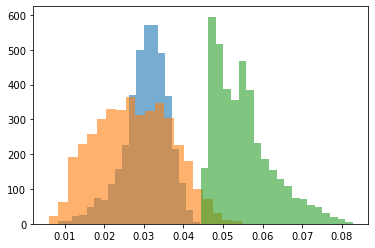

In [33]:
plt.hist(res_naive.numpy(), bins=20, alpha=0.6)
plt.hist(res_bt.numpy(), bins=20, alpha=0.6)
plt.hist(res_minimax.numpy(), bins=20, alpha=0.6)